In [33]:
import os
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader,Dataset
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torchvision.models import mobilenet_v2
from PIL import Image
from tqdm import tqdm
import seaborn as sns

In [2]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("ahemateja19bec1025/facemask-dataset")

print("Path to dataset files:", path)
os.listdir(path)

c:\Users\PC\anaconda3\envs\pytorch\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


100%|██████████| 50.4M/50.4M [00:19<00:00, 2.72MB/s]


Extracting files...
Path to dataset files: C:\Users\PC\.cache\kagglehub\datasets\ahemateja19bec1025\facemask-dataset\versions\3


['dataset', 'labels_FaceMask.csv']

In [4]:
BASE_PATH = os.path.join(path, "dataset","dataset")

In [5]:
class_names = os.listdir(BASE_PATH)
class_num =  len(class_names)

In [13]:
def display_images(path,num_sample=9):
    fig = plt.figure(figsize=(10, 10))
    images = os.listdir(path)
    for i in range(num_sample):
        img = Image.open(os.path.join(path,images[i]))
        fig.add_subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis("off")
    plt.show()
    plt.tight_layout()

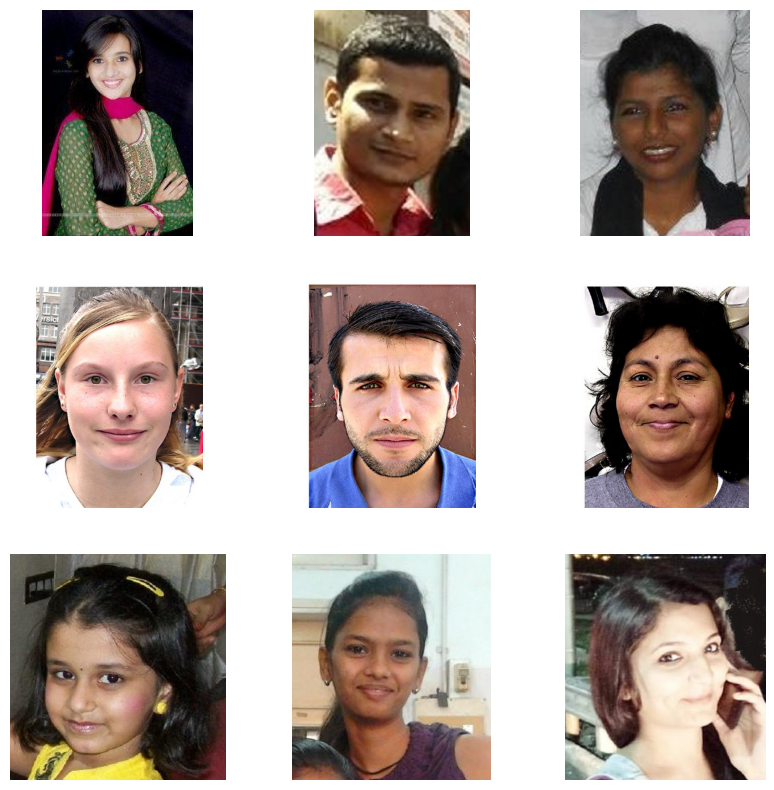

<Figure size 640x480 with 0 Axes>

In [14]:
display_images(f"{BASE_PATH}/{class_names[0]}")

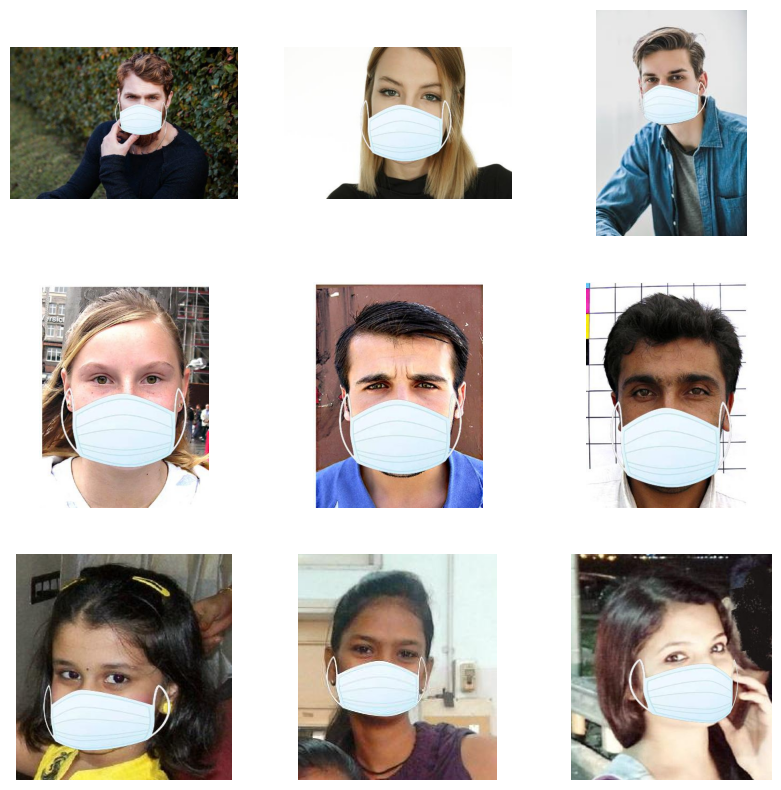

<Figure size 640x480 with 0 Axes>

In [15]:
display_images(f"{BASE_PATH}/{class_names[1]}")

In [17]:
import splitfolders
splitfolders.ratio(BASE_PATH, output="data", seed=1337, ratio=(.8, .2))

Copying files: 1376 files [00:02, 669.07 files/s]


In [18]:
class FaceMaskDataset():
    def __init__(self,root,transforms):
        self.root = root
        self.transforms = transforms
        self.class_names = os.listdir(root)
        self.images = []
        for i, class_name in enumerate(self.class_names):
            for image in os.listdir(os.path.join(root,class_name)):
                self.images.append((os.path.join(root,class_name,image),i))
    def __len__(self):
        return len(self.images)
    def __getitem__(self,idx):
        img_path,label = self.images[idx]
        img = Image.open(img_path)
        img = self.transforms(img)
        return img,label
        

In [19]:
train_transforms = transforms.Compose([
    transforms.Resize((32,32)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

val_transforms = transforms.Compose([
    transforms.Resize((32, 32)),         # Boyutlandırma (Validation için önemli)
    transforms.ToTensor(),                 # Tensöre çevirme
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalizasyon
])


In [20]:
train_dataset = FaceMaskDataset("data/train",train_transforms)
val_dataset = FaceMaskDataset("data/val",val_transforms)

In [71]:
train_loader = DataLoader(train_dataset,batch_size=32,shuffle=True)
val_loader = DataLoader(val_dataset,batch_size=32,shuffle=True)

In [72]:
for img,label in train_loader:
    print(img.shape)
    print(label)
    break

torch.Size([32, 3, 32, 32])
tensor([1, 1, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0,
        1, 1, 0, 1, 0, 1, 0, 1])


In [73]:
class FaceMaskDetector(nn.Module):
    def __init__(self,class_num):
        super(FaceMaskDetector,self).__init__()
        self.model = mobilenet_v2(pretrained=True)
        in_features = self.model.classifier[1].in_features
        self.model.classifier[1] = nn.Linear(in_features,class_num)
    def forward(self,x):
        return self.model(x)

In [74]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = FaceMaskDetector(class_num).to(device)
model.to(device)

c:\Users\PC\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\PC\anaconda3\envs\pytorch\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


FaceMaskDetector(
  (model): MobileNetV2(
    (features): Sequential(
      (0): Conv2dNormActivation(
        (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU6(inplace=True)
      )
      (1): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU6(inplace=True)
          )
          (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        )
      )
      (2): InvertedResidual(
        (conv): Sequential(
          (0): Conv2dNormActivation(
            (0): Conv2d(16, 96, kernel_size

In [75]:
from torchsummary import summary
summary(model,(3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 16, 16]             864
       BatchNorm2d-2           [-1, 32, 16, 16]              64
             ReLU6-3           [-1, 32, 16, 16]               0
            Conv2d-4           [-1, 32, 16, 16]             288
       BatchNorm2d-5           [-1, 32, 16, 16]              64
             ReLU6-6           [-1, 32, 16, 16]               0
            Conv2d-7           [-1, 16, 16, 16]             512
       BatchNorm2d-8           [-1, 16, 16, 16]              32
  InvertedResidual-9           [-1, 16, 16, 16]               0
           Conv2d-10           [-1, 96, 16, 16]           1,536
      BatchNorm2d-11           [-1, 96, 16, 16]             192
            ReLU6-12           [-1, 96, 16, 16]               0
           Conv2d-13             [-1, 96, 8, 8]             864
      BatchNorm2d-14             [-1, 9

Train

In [76]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(),lr=0.001)

import matplotlib.pyplot as plt
from tqdm import tqdm

history = {"train_loss": [], "val_loss": [], "val_acc": []}

def train_validate_model(model, train_loader, val_loader, criterion, optimizer, epochs=5):
    for epoch in range(epochs):
        model.train()
        train_loss = 0.0
        
        for images, labels in tqdm(train_loader):
            images, labels = images.to(device), labels.to(device)
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()

        epoch_loss = train_loss / len(train_loader)
        history["train_loss"].append(epoch_loss)

        print(f"Epoch {epoch+1}/{epochs}, Train Loss: {epoch_loss:.4f}")

        model.eval()
        val_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in tqdm(val_loader):
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()
                
        val_epoch_loss = val_loss / len(val_loader)
        val_accuracy = correct / total
        history["val_loss"].append(val_epoch_loss)
        history["val_acc"].append(val_accuracy)

        print(f"Val Loss: {val_epoch_loss:.4f}, Val Accuracy: {val_accuracy:.4f}")

train_validate_model(model, train_loader, val_loader, criterion, optimizer, epochs=10)

 14%|█▍        | 5/35 [00:01<00:06,  4.44it/s]

100%|██████████| 35/35 [00:08<00:00,  4.31it/s]


Epoch 1/10, Train Loss: 0.4143


100%|██████████| 9/9 [00:01<00:00,  8.34it/s]


Val Loss: 0.1791, Val Accuracy: 0.9384


100%|██████████| 35/35 [00:07<00:00,  4.52it/s]


Epoch 2/10, Train Loss: 0.1246


100%|██████████| 9/9 [00:01<00:00,  8.83it/s]


Val Loss: 0.0935, Val Accuracy: 0.9783


100%|██████████| 35/35 [00:06<00:00,  5.09it/s]


Epoch 3/10, Train Loss: 0.0749


100%|██████████| 9/9 [00:00<00:00,  9.09it/s]


Val Loss: 0.0830, Val Accuracy: 0.9710


100%|██████████| 35/35 [00:06<00:00,  5.01it/s]


Epoch 4/10, Train Loss: 0.0710


100%|██████████| 9/9 [00:00<00:00,  9.34it/s]


Val Loss: 0.0620, Val Accuracy: 0.9710


100%|██████████| 35/35 [00:07<00:00,  4.74it/s]


Epoch 5/10, Train Loss: 0.0459


100%|██████████| 9/9 [00:00<00:00,  9.29it/s]


Val Loss: 0.0818, Val Accuracy: 0.9710


100%|██████████| 35/35 [00:07<00:00,  4.69it/s]


Epoch 6/10, Train Loss: 0.1060


100%|██████████| 9/9 [00:01<00:00,  8.57it/s]


Val Loss: 0.0614, Val Accuracy: 0.9891


100%|██████████| 35/35 [00:07<00:00,  4.92it/s]


Epoch 7/10, Train Loss: 0.0685


100%|██████████| 9/9 [00:01<00:00,  8.78it/s]


Val Loss: 0.0853, Val Accuracy: 0.9638


100%|██████████| 35/35 [00:07<00:00,  4.76it/s]


Epoch 8/10, Train Loss: 0.0439


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


Val Loss: 0.0444, Val Accuracy: 0.9855


100%|██████████| 35/35 [00:06<00:00,  5.04it/s]


Epoch 9/10, Train Loss: 0.0263


100%|██████████| 9/9 [00:01<00:00,  8.41it/s]


Val Loss: 0.0345, Val Accuracy: 0.9928


100%|██████████| 35/35 [00:07<00:00,  4.71it/s]


Epoch 10/10, Train Loss: 0.0152


100%|██████████| 9/9 [00:01<00:00,  8.72it/s]

Val Loss: 0.0278, Val Accuracy: 0.9928


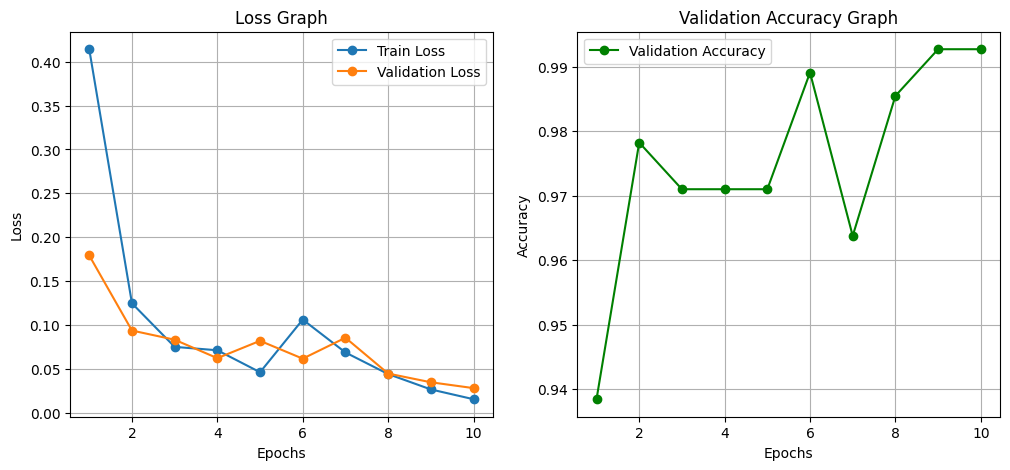

In [77]:

def plot_history(history):
    epochs = range(1, len(history["train_loss"]) + 1)

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Train Loss", marker="o")
    plt.plot(epochs, history["val_loss"], label="Validation Loss", marker="o")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Loss Graph")
    plt.legend()
    plt.grid()
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["val_acc"], label="Validation Accuracy", marker="o", color="green")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.title("Validation Accuracy Graph")
    plt.legend()
    plt.grid()

    plt.show()

plot_history(history)


100%|██████████| 9/9 [00:00<00:00,  9.21it/s]


              precision    recall  f1-score   support

           0       1.00      0.99      0.99       138
           1       0.99      1.00      0.99       138

    accuracy                           0.99       276
   macro avg       0.99      0.99      0.99       276
weighted avg       0.99      0.99      0.99       276



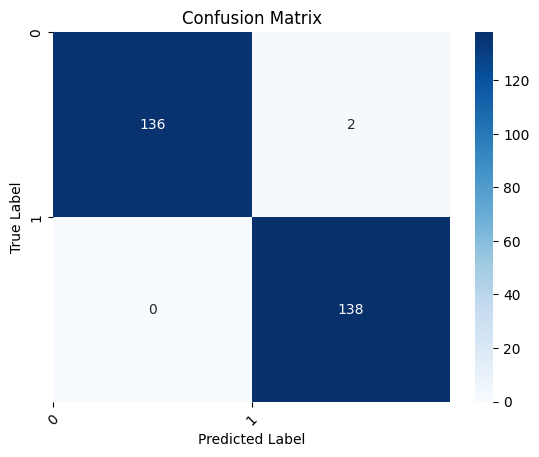

In [78]:
pred = []
true = []
model.eval()
with torch.no_grad():
    for images, labels in tqdm(val_loader):
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        pred.extend(predicted.cpu().numpy())
        true.extend(labels.cpu().numpy())
        
pred = np.array(pred)
true = np.array(true)

from sklearn.metrics import classification_report, confusion_matrix

print(classification_report(true, pred, target_names=class_names))

cm = confusion_matrix(true, pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xticks(range(len(class_names)), class_names, rotation=45)
plt.yticks(range(len(class_names)), class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
import random
import matplotlib.pyplot as plt

def plot_prediction(images, labels, preds, class_names):
    fig = plt.figure(figsize=(15, 15))

    num_samples = min(25, len(images))  
    indices = random.sample(range(len(images)), num_samples) 

    for i, idx in enumerate(indices):
        img = images[idx].cpu().permute(1, 2, 0).numpy()  
        fig.add_subplot(5, 5, i+1)
        plt.imshow(img)
        plt.axis("off")


        actual_label = class_names[int(labels[idx])]  
        predicted_label = class_names[int(preds[idx])]

        plt.title(f"Actual: {actual_label}\nPredicted: {predicted_label}", fontsize=10)

    plt.tight_layout()
    plt.show()


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7582842..2.4308496].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.64].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8610327..1.9602616].


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5280112..2.5702832].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8606442..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7411594..1.9776908].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.5699118..2.3959913].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.117904..2.622571].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8267832..2.465708].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8781574..1

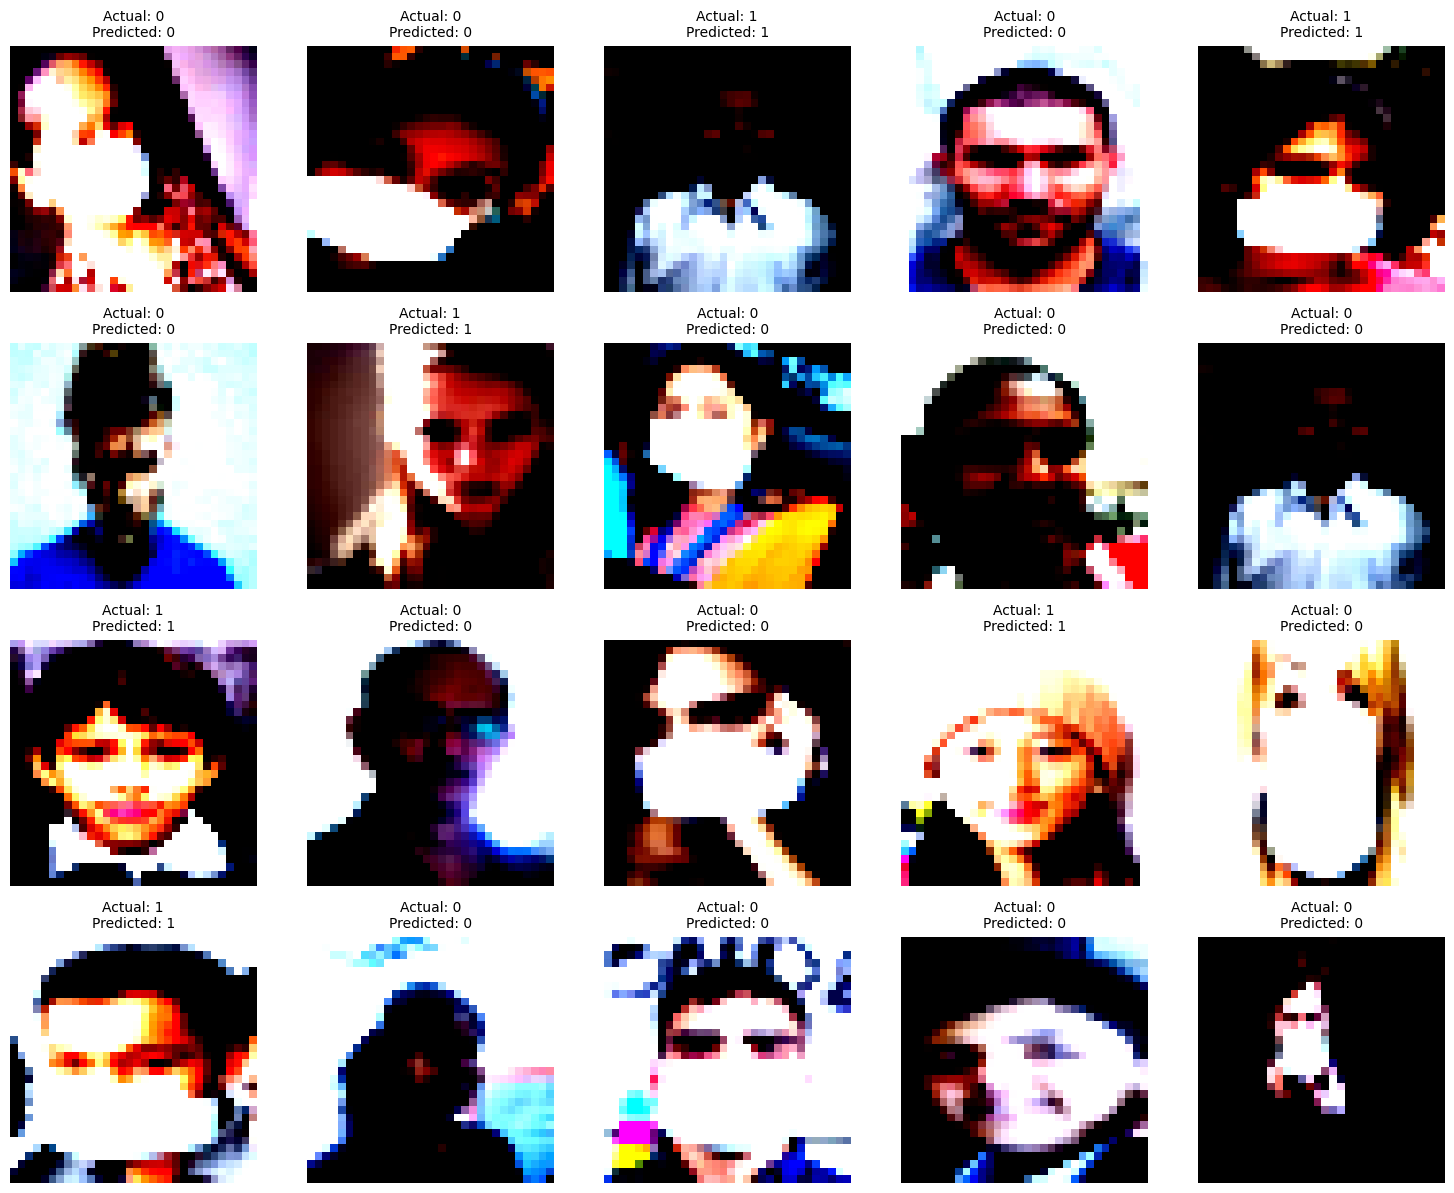

In [82]:
plot_prediction(images, true, pred,class_names)